# Serialization Speed Comparison of Data Exchange Formats

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

## Basic anaylsis and preparation

In [2]:
df = pd.read_excel('../results/elapsedTimes.xlsx', names=["Use Cases", "Data Formats", "Speed"], dtype={"Use Case": str, "Format": str, "Speed": np.float64})

c:\Users\Bianca\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Use Cases     224 non-null    object 
 1   Data Formats  224 non-null    object 
 2   Speed         224 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.4+ KB


In [4]:
df["Speed"].describe()

count    2.240000e+02
mean     4.642913e+07
std      6.279424e+08
min      8.869000e+02
25%      4.141275e+03
50%      1.069650e+04
75%      3.436480e+04
max      9.354811e+09
Name: Speed, dtype: float64

In [5]:
# convert to micro seconds
df["Speed"] = df["Speed"] / 1000 
df["Speed"] = round(df["Speed"], 2)

In [6]:
# shorten names of data formats
df = df.replace({'Data Formats': ['Cap\'n Proto (packed)', 'Cap\'n Proto (unpacked)', 'CSV (with header)', 'Ion Binary', 'Java Serialization']}, 
                {'Data Formats': ['Cap\'n (packed)', 'Cap\'n (unpacked)', 'CSV (header)', 'Ion (binary)', 'Java']})

In [7]:
use_cases = df["Use Cases"].sort_values().unique()
use_cases_without_image = np.delete(use_cases, np.where(use_cases == "ImageData"))
formats = df["Data Formats"].unique()
categories = ["Binary", "Textual", "Schema-driven", "Schema-less"]

print(use_cases)
print(formats)

['HeartData' 'HttpResponse' 'ImageData' 'ImageDescriptor' 'LocationData'
 'Person' 'SensorValue' 'SmartLightController']
['INI' "Cap'n (packed)" 'JSON' 'Avro' 'YAML' 'Protobuf' 'FlatBuffers'
 'RDF' 'Ion (binary)' 'CBOR' 'Hessian' 'TLV' 'Thrift' 'RDF Turtle'
 'UBJSON' 'CSV' 'XDR' 'Ion' 'Smile' 'BSON' 'Java' "Cap'n (unpacked)" 'XML'
 'EXI' 'CSV (header)' 'FlexBuffers' 'MessagePack' 'TOML']


In [8]:
dfa = df.pivot(index="Data Formats", columns="Use Cases", values="Speed")
dfa = dfa.astype('float64')
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, Avro to YAML
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HeartData             28 non-null     float64
 1   HttpResponse          28 non-null     float64
 2   ImageData             28 non-null     float64
 3   ImageDescriptor       28 non-null     float64
 4   LocationData          28 non-null     float64
 5   Person                28 non-null     float64
 6   SensorValue           28 non-null     float64
 7   SmartLightController  28 non-null     float64
dtypes: float64(8)
memory usage: 2.0+ KB


## Visualizations

### Overview

In [9]:
dfb=dfa.copy()
for k in dfa.keys():
    dfb[k] = dfb[k].div(dfa[k].min()).round(2).astype('float64')
dfb = dfb.transpose()
dfb.head()

Data Formats,Avro,BSON,CBOR,CSV,CSV (header),Cap'n (packed),Cap'n (unpacked),EXI,FlatBuffers,FlexBuffers,...,RDF,RDF Turtle,Smile,TLV,TOML,Thrift,UBJSON,XDR,XML,YAML
Use Cases,,,,,,,,,,,,,,,,,,,,,
HeartData,8.44,10.74,6.25,8.78,2.28,12.08,1.00,89.15,9.16,6.64,...,70.78,21.45,1.58,1.56,2.16,18.65,6.71,3.55,1.80,11.79
HttpResponse,5.56,4.98,2.57,6.74,1.69,10.02,1.59,115.04,5.20,3.23,...,198.65,58.93,1.07,1.70,16.35,18.01,10.50,1.84,1.81,29.06
ImageData,1.60,2.83,1.79,27.96,26.83,6.05,2.43,131.94,2.18,2.03,...,89.59,5439.20,4.71,1.70,15.47,2.73,79.62,1.53,7.46,78.27
ImageDescriptor,11.97,27.66,7.99,8.18,2.10,13.21,1.00,185.81,4.46,5.40,...,147.97,37.44,3.16,1.82,3.85,6.15,8.54,3.80,4.65,19.98
LocationData,19.83,13.90,2.65,4.09,1.86,12.17,1.12,103.04,12.06,2.95,...,48.07,20.86,1.67,1.15,1.63,21.85,5.32,4.61,2.61,7.55


In [10]:
# adjust annotations in plot
def format_annotation(x):
    if x >= 1000: 
        return f"{x:.1e}".replace("e+", "\ne+")
    else: 
        return f"{x:.1f}"

annot_text = np.vectorize(format_annotation)(dfb)


Text(278.671875, 0.5, 'Use Cases')

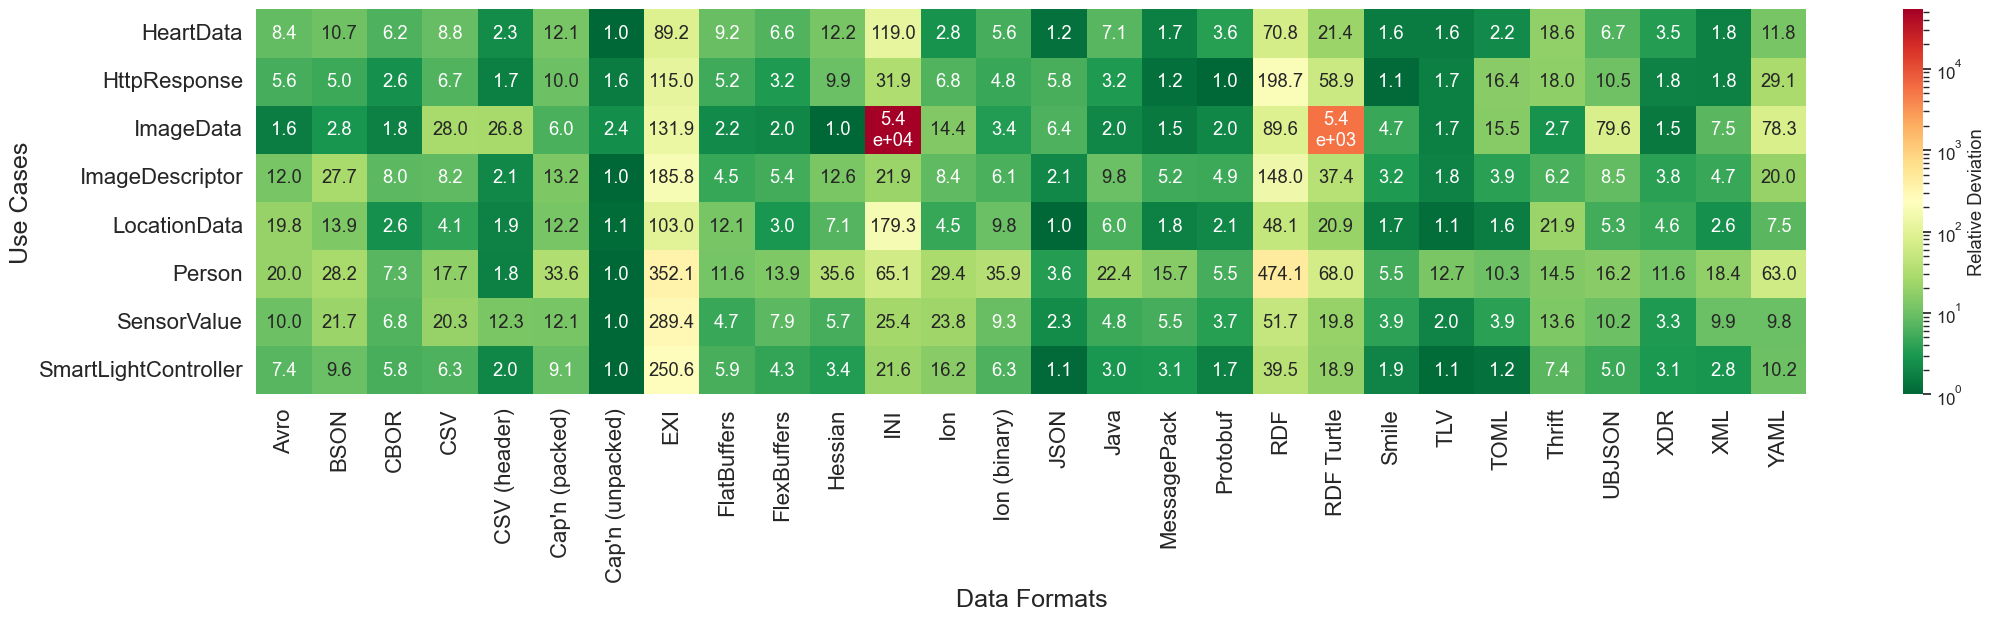

In [11]:
# Plot heatmap of relative deviations form best data format per use case
plt.figure(figsize=(25, 5))
sns.set(font_scale=1.1)
sns.heatmap(
    dfb,
    annot=annot_text,
    cmap="RdYlGn_r",
    fmt="",
    cbar_kws={"label": "Relative Deviation"},
    norm=LogNorm()
)

plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.xlabel("Data Formats", fontsize=18) 
plt.ylabel("Use Cases", fontsize=18) 

In [12]:
# drop image data and repeat
dfc=dfb.drop(['ImageData'])
dfc.head()

Data Formats,Avro,BSON,CBOR,CSV,CSV (header),Cap'n (packed),Cap'n (unpacked),EXI,FlatBuffers,FlexBuffers,...,RDF,RDF Turtle,Smile,TLV,TOML,Thrift,UBJSON,XDR,XML,YAML
Use Cases,,,,,,,,,,,,,,,,,,,,,
HeartData,8.44,10.74,6.25,8.78,2.28,12.08,1.00,89.15,9.16,6.64,...,70.78,21.45,1.58,1.56,2.16,18.65,6.71,3.55,1.80,11.79
HttpResponse,5.56,4.98,2.57,6.74,1.69,10.02,1.59,115.04,5.20,3.23,...,198.65,58.93,1.07,1.70,16.35,18.01,10.50,1.84,1.81,29.06
ImageDescriptor,11.97,27.66,7.99,8.18,2.10,13.21,1.00,185.81,4.46,5.40,...,147.97,37.44,3.16,1.82,3.85,6.15,8.54,3.80,4.65,19.98
LocationData,19.83,13.90,2.65,4.09,1.86,12.17,1.12,103.04,12.06,2.95,...,48.07,20.86,1.67,1.15,1.63,21.85,5.32,4.61,2.61,7.55
Person,20.03,28.22,7.30,17.66,1.75,33.58,1.00,352.09,11.60,13.89,...,474.06,68.02,5.48,12.65,10.30,14.52,16.21,11.60,18.40,63.03


Text(278.671875, 0.5, 'Use Cases')

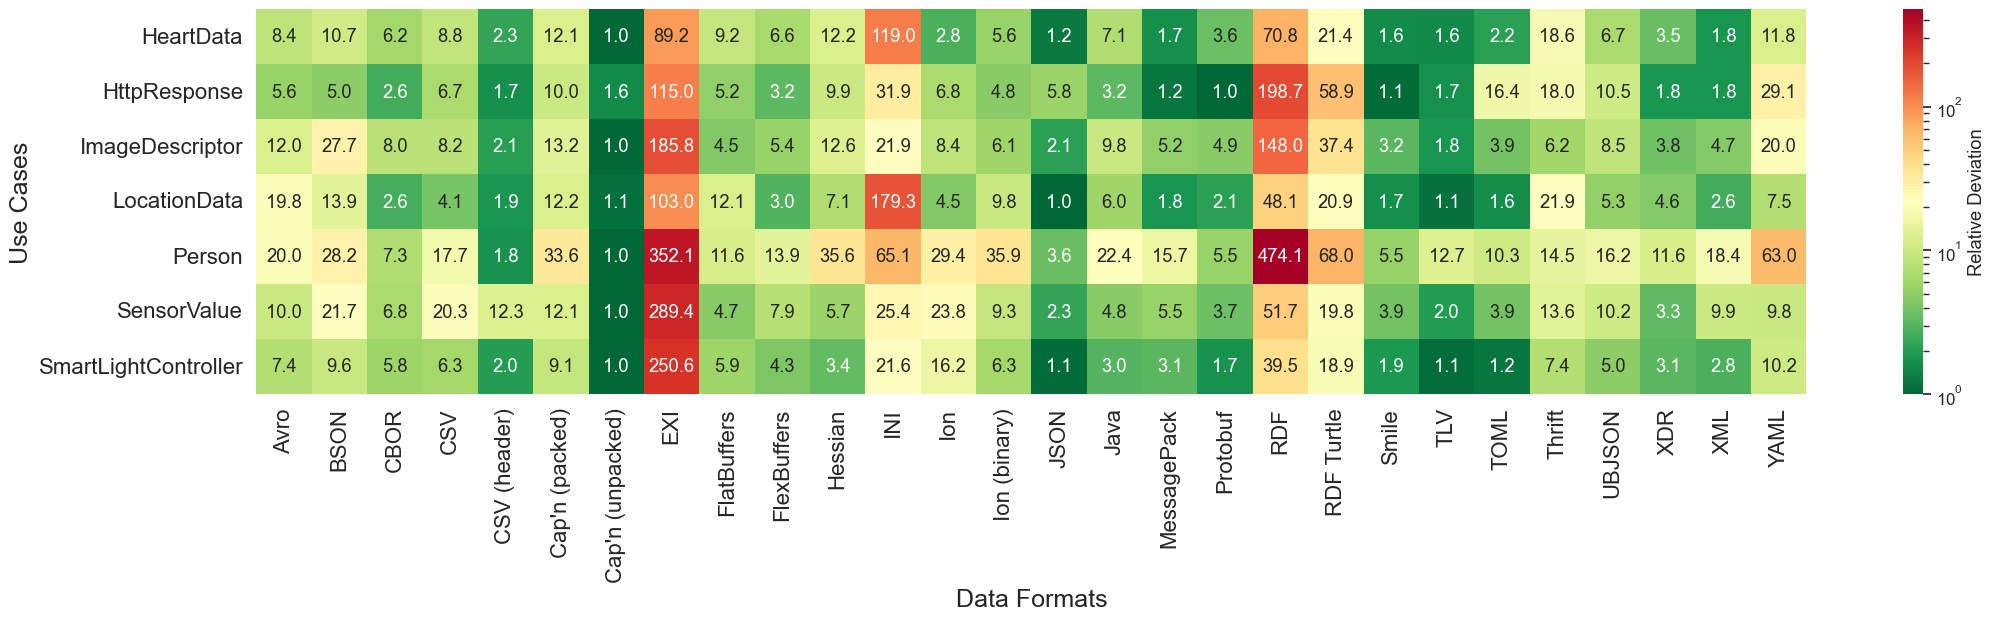

In [13]:
annot_text2 = np.vectorize(format_annotation)(dfc)

# Plot heatmap of relative deviations form best data format per use case (without image)
plt.figure(figsize=(25, 5))
sns.set(font_scale=1.1)
sns.heatmap(
    dfc,
    annot=annot_text2,
    cmap="RdYlGn_r",
    fmt="",
    cbar_kws={"label": "Relative Deviation"},
    norm=LogNorm()
)

plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)
plt.xlabel("Data Formats", fontsize=18) 
plt.ylabel("Use Cases", fontsize=18) 

### Comparison to JSON

In [14]:
dfd=pd.DataFrame()
for t in dfa.keys():
    if t != 'ImageData':
        dft=pd.DataFrame()
        dft['Use Cases'] = list([t,t,t,t])
        w = list(dfa.nsmallest(3,t)[t].index)
        w.append('JSON')
        dft['Data Formats'] = w
        x = list(dfa.nsmallest(3,t)[t])
        x.append(dfa[t].loc['JSON'])     
        dft['Speed']= x
        dfd = pd.concat([dfd,dft])
dfd

,Use Cases,Data Formats,Speed
0,HeartData,Cap'n (unpacked),1.59
1,HeartData,JSON,1.99
2,HeartData,TLV,2.48
3,HeartData,JSON,1.99
0,HttpResponse,Protobuf,1.07
1,HttpResponse,Smile,1.15
2,HttpResponse,MessagePack,1.32
3,HttpResponse,JSON,6.16
0,ImageDescriptor,Cap'n (unpacked),1.31
1,ImageDescriptor,TLV,2.38


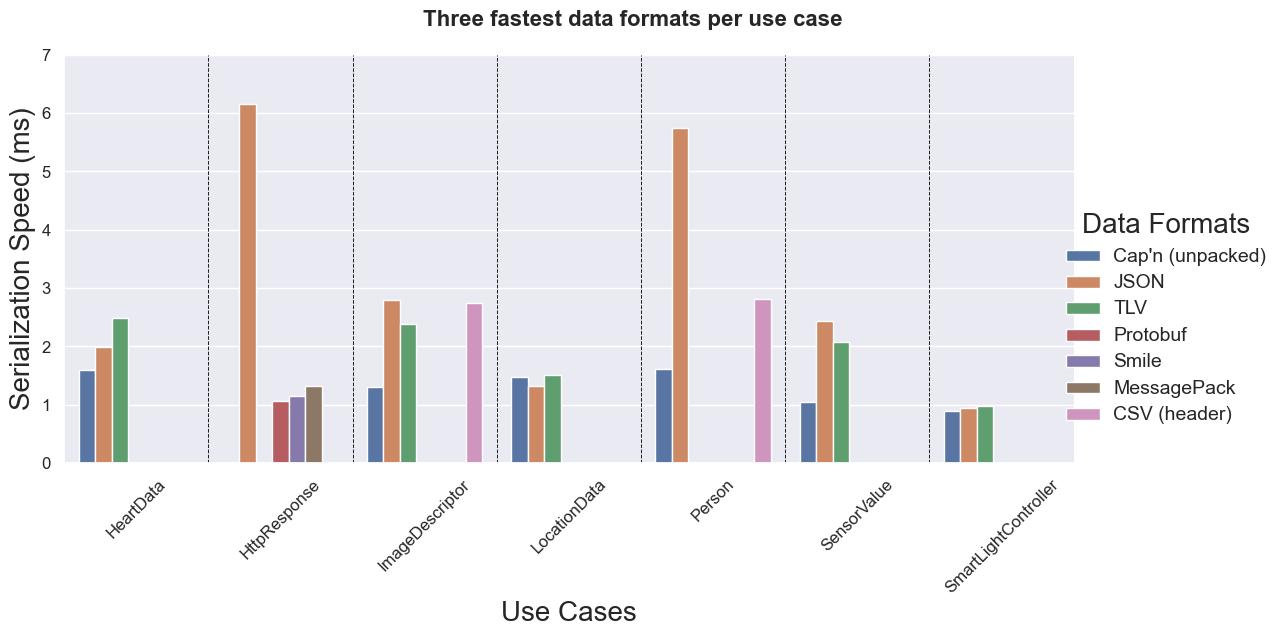

In [15]:
# visualize the fastest 3 data formats per use case
ax=sns.catplot(
    x="Use Cases",       
    y="Speed",       
    hue="Data Formats",
    height=5,
    data=dfd,     
    kind="bar",
    aspect=2.2,
    legend=True
)
ax.set(ylim=(0, 7))
ax.set(xlim=(-0.5, 6.5))
ax.set_xticklabels(fontsize=12,rotation=45)
ax.set_yticklabels(fontsize=12)
ax.set_xlabels(fontsize=20)
ax.set_ylabels("Serialization Speed (ms)", fontsize=20)
ax.fig.suptitle("Three fastest data formats per use case", fontsize=16, fontweight='bold', y=1.05)
plt.axvline(x = 0.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 1.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 2.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 3.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 4.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 5.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 6.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.setp(ax._legend.get_title(), fontsize=20)
plt.setp(ax._legend.get_texts(), fontsize=14)

plt.show()

In [16]:
dfi= dfa.copy()
for k in dfi.keys():
    if k != 'ImageData':
        dfi = dfi.drop(k,axis=1)
dfi['image_rel'] = dfi['ImageData'].div(dfa['ImageData'].iloc[15])
dfi['Data Formats'] = dfi.index
dfi

Use Cases,ImageData,image_rel,Data Formats
Data Formats,,,
Avro,279.12,0.780537,Avro
BSON,493.32,1.379530,BSON
CBOR,313.09,0.875531,CBOR
CSV,4879.03,13.643820,CSV
CSV (header),4680.79,13.089457,CSV (header)
Cap'n (packed),1054.94,2.950056,Cap'n (packed)
Cap'n (unpacked),424.37,1.186717,Cap'n (unpacked)
EXI,23021.02,64.376454,EXI
FlatBuffers,380.55,1.064178,FlatBuffers


Text(0.5, 1.05, 'Image data test case')

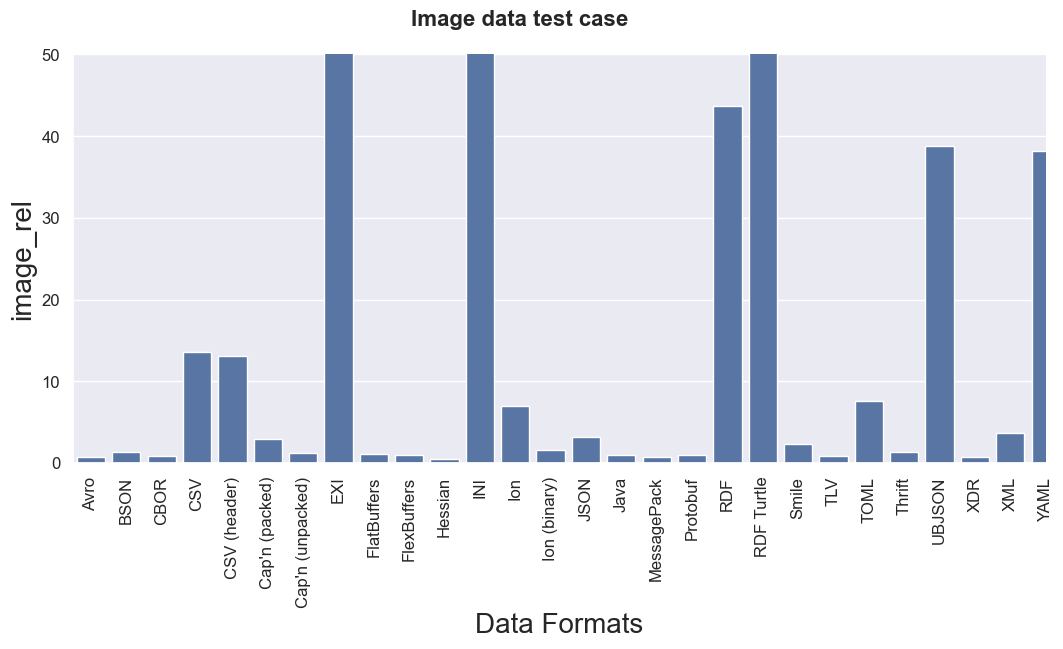

In [17]:
# visualize values of the image use case (relative values instead of absolute)
ax=sns.catplot(
    x="Data Formats",       
    y="image_rel", 
    hue=None,
    height=5,
    data=dfi,     
    kind="bar",
    aspect=2.2,
    legend=False
)
ax.set(ylim=(0, 50))
ax.set(xlim=(-0.5, 7))
ax.set_xticklabels(fontsize=12,rotation=90)
ax.set_yticklabels(fontsize=12)
ax.set_xlabels(fontsize=20)
ax.set_ylabels(fontsize=20)
ax.fig.suptitle("Image data test case", fontsize=16, fontweight='bold', y=1.05)

In [18]:
base_values = df[df["Data Formats"] == "JSON"]

def percentage_change(value, base): 
    increase = value - base
    return round((increase / base) * 100, 2)

def create_change_df(data, with_image = False): 
    change_df = pd.DataFrame(columns=["Use Cases", "Data Formats", "Speed", "Relative", "Change"])

    for i, row in data.iterrows(): 
        value = row["Speed"]
        case = row["Use Cases"]
        if not with_image and case == "ImageData": continue 
        base = base_values.loc[base_values["Use Cases"] == case]
        base = base["Speed"].iloc[0]
        relative = round(value / base, 2)

        change_df.loc[i] = [case, row["Data Formats"], value, relative, percentage_change(value, base)]
        
    return change_df
    
change_df = create_change_df(df)
change_df = change_df[change_df["Data Formats"] != "JSON"] # remove json value because change is always 0
change_df

,Use Cases,Data Formats,Speed,Relative,Change
0,SensorValue,INI,26.67,10.98,997.53
1,LocationData,INI,236.67,179.30,17829.55
3,HttpResponse,INI,34.12,5.54,453.90
4,ImageDescriptor,INI,28.74,10.30,930.11
5,Person,INI,104.74,18.25,1724.74
...,...,...,...,...,...
219,HttpResponse,TOML,17.49,2.84,183.93
220,ImageDescriptor,TOML,5.04,1.81,80.65
221,Person,TOML,16.58,2.89,188.85
222,HeartData,TOML,3.43,1.72,72.36


In [19]:
pivot_df = change_df.pivot(index='Data Formats', columns='Use Cases', values='Change')
pivot_df

Use Cases,HeartData,HttpResponse,ImageDescriptor,LocationData,Person,SensorValue,SmartLightController
Data Formats,,,,,,,
Avro,574.37,-3.41,462.01,1882.58,461.85,332.92,591.58
BSON,758.29,-13.47,1198.57,1290.15,691.46,837.86,794.74
CBOR,398.99,-55.36,275.27,165.15,104.70,193.00,443.16
CSV,601.51,17.05,284.23,309.09,395.30,775.72,486.32
CSV (header),82.41,-70.62,-1.43,86.36,-51.05,433.74,90.53
Cap'n (packed),865.33,74.03,520.07,1116.67,841.81,423.87,751.58
Cap'n (unpacked),-20.10,-72.40,-53.05,12.12,-71.95,-56.79,-6.32
EXI,7023.12,1898.21,8624.37,10203.79,9775.61,12403.29,23377.89
FlatBuffers,631.66,-9.74,109.32,1106.06,225.44,101.65,454.74


In [20]:
dfd=pd.DataFrame()
for t in pivot_df.keys():
    dft=pd.DataFrame()
    dft['Use Cases'] = list([t,t,t])
    w = list(pivot_df.nsmallest(3,t)[t].index)
    dft['Data Formats'] = w
    x = list(pivot_df.nsmallest(3,t)[t])
    dft['Difference']= x
    dfd = pd.concat([dfd,dft])
dfd

,Use Cases,Data Formats,Difference
0,HeartData,Cap'n (unpacked),-20.10
1,HeartData,TLV,24.62
2,HeartData,Smile,26.13
0,HttpResponse,Protobuf,-82.63
1,HttpResponse,Smile,-81.33
2,HttpResponse,MessagePack,-78.57
0,ImageDescriptor,Cap'n (unpacked),-53.05
1,ImageDescriptor,TLV,-14.70
2,ImageDescriptor,CSV (header),-1.43
0,LocationData,Cap'n (unpacked),12.12


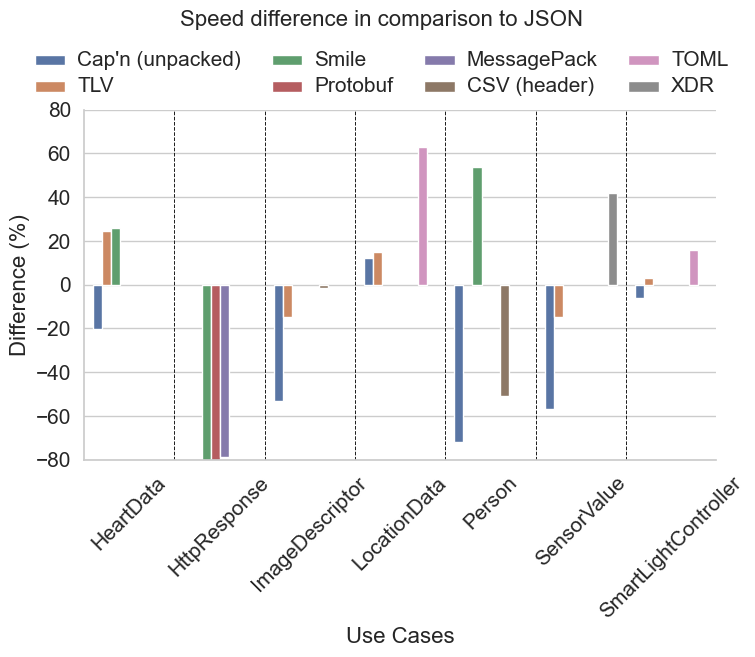

In [28]:
# visualize the difference in measured speed of the three best data formats per use case in comparison to json 
ax=sns.catplot(
    x="Use Cases",       
    y="Difference",       
    hue="Data Formats",
    height=5,
    data=dfd,     
    kind="bar",
    aspect=1.5,
    legend=True,
    legend_out=False,
    order=use_cases_without_image
)
ax.set(ylim=(-80, 80))
ax.set(xlim=(-0.5, 6.5))
ax.set_xticklabels(fontsize=15,rotation=45)
ax.set_yticklabels(fontsize=15)
ax.set_xlabels(fontsize=16)
ax.set_ylabels("Difference (%)", fontsize=16)
plt.suptitle("Speed difference in comparison to JSON", fontsize=16, y=1.1)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 0.9), ncol=4, title=None, frameon=False,
)
plt.axvline(x = 0.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 1.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 2.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 3.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 4.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 5.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.axvline(x = 6.5, ymin=0, ymax=1, color = 'k',linestyle='--',linewidth=0.7)
plt.setp(ax._legend.get_texts(), fontsize=15)
plt.subplots_adjust(top=0.9, bottom=0.2)
plt.show()

### Comparison of categories

In [22]:
binary_formats = ["Avro", "BSON", "Cap'n (packed)", "Cap'n (unpacked)", "CBOR", "EXI", "FlatBuffers", "FlexBuffers", "Hessian", "Ion (binary)", "Java", "MessagePack", "Protobuf", "Smile", "Thrift", "TLV", "UBJSON", "XDR"]
textual_formats =  ["CSV (header)", "CSV", "INI", "Ion", "JSON", "RDF", "TOML", "XML", "YAML"]

schema_driven_formats = ["Avro", "Cap'n (packed)", "Cap'n (unpacked)", "FlatBuffers", "Protobuf", "Thrift", "XDR"]
schema_less_formats = ["BSON", "CBOR", "CSV (header)", "CSV", "EXI", "FlexBuffers", "Hessian", "INI", "Ion", "Ion (binary)", "Java", "JSON", "MessagePack", "RDF", "Smile", "TLV", "TOML", "UBJSON", "XML", "YAML"]

binary_df = df[np.isin(df, binary_formats).any(axis=1)]
textual_df = df[np.isin(df, textual_formats).any(axis=1)]
schema_driven_df = df[np.isin(df, schema_driven_formats).any(axis=1)]
schema_less_df = df[np.isin(df, schema_less_formats).any(axis=1)]

In [23]:
binary_df.insert(0, "Format Type", "Binary")
textual_df.insert(0, "Format Type","Textual")
schema_driven_df.insert(0, "Format Type","Schema-Driven")
schema_less_df.insert(0, "Format Type","Schema-Less")

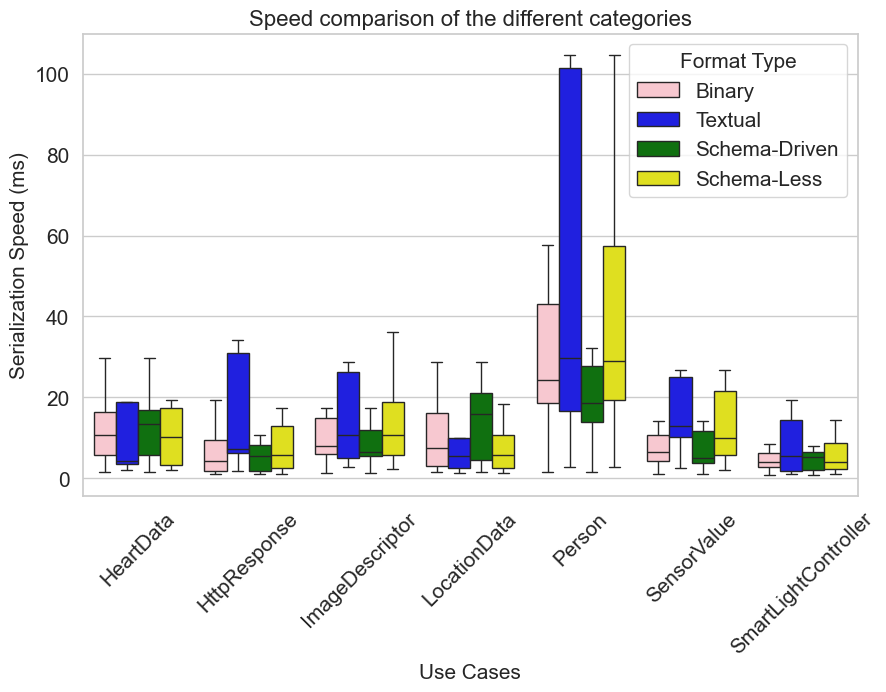

In [24]:
# visualize the different categories and their performance differences
df_combined = pd.concat([binary_df, textual_df, schema_driven_df, schema_less_df])
df_combined = df_combined[df_combined["Use Cases"] != "ImageData"]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x="Use Cases", 
    y="Speed", 
    hue="Format Type",  
    data=df_combined, 
    order=use_cases_without_image,
    palette={"Binary": "pink", "Textual": "blue", "Schema-Driven": "green", "Schema-Less": "yellow"}, 
    showfliers=False,
)

plt.title("Speed comparison of the different categories", fontsize=16)
plt.ylabel("Serialization Speed (ms)", fontsize=15)
plt.xlabel("Use Cases", fontsize=15)
ax.set_xticks(use_cases_without_image)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=15)
ax.set_yticks(np.arange(0, 110, 20))
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
plt.legend(title="Format Type", fontsize=15, title_fontsize=15)
plt.show()

## Demonstation of energy savings

Assuming a standard occupancy sensor that transmits a data packet per second 

In [25]:
#assumtions:
working_hours = 24
data_points_per_sec = 1
data_point_per_hour = data_points_per_sec*60*60
sensor_protobuf = dfa['SensorValue'].loc['Protobuf']
sensor_json = dfa['SensorValue'].loc['JSON']

time_range=np.array(range(0,31))
print(time_range)

space_proto = time_range * sensor_protobuf * data_point_per_hour * working_hours
print(space_proto)

space_json = time_range * sensor_json * data_point_per_hour * working_hours
print(space_json)

dfs=pd.DataFrame()
dfs['time']=time_range
dfs['Protobuf']=space_proto
dfs['JSON']=space_json
dfs['Protobuf (MB)'] = dfs['Protobuf'].div(1024*1024)
dfs['JSON (MB)'] =  dfs['JSON'].div(1024*1024)
dfs

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
[       0.   337824.   675648.  1013472.  1351296.  1689120.  2026944.
  2364768.  2702592.  3040416.  3378240.  3716064.  4053888.  4391712.
  4729536.  5067360.  5405184.  5743008.  6080832.  6418656.  6756480.
  7094304.  7432128.  7769952.  8107776.  8445600.  8783424.  9121248.
  9459072.  9796896. 10134720.]
[      0.  209952.  419904.  629856.  839808. 1049760. 1259712. 1469664.
 1679616. 1889568. 2099520. 2309472. 2519424. 2729376. 2939328. 3149280.
 3359232. 3569184. 3779136. 3989088. 4199040. 4408992. 4618944. 4828896.
 5038848. 5248800. 5458752. 5668704. 5878656. 6088608. 6298560.]


,time,Protobuf,JSON,Protobuf (MB),JSON (MB)
0,0,0.0,0.0,0.000000,0.000000
1,1,337824.0,209952.0,0.322174,0.200226
2,2,675648.0,419904.0,0.644348,0.400452
3,3,1013472.0,629856.0,0.966522,0.600677
4,4,1351296.0,839808.0,1.288696,0.800903
5,5,1689120.0,1049760.0,1.610870,1.001129
6,6,2026944.0,1259712.0,1.933044,1.201355
7,7,2364768.0,1469664.0,2.255219,1.401581
8,8,2702592.0,1679616.0,2.577393,1.601807
9,9,3040416.0,1889568.0,2.899567,1.802032
